# Вариант 2

Загрузить файлы и информацией о лицах, перевести в тензорный формат и построить модель классификации.

In [104]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix

In [105]:
import numpy as np
from PIL import Image

images = np.load('/content/drive/MyDrive/ML/кр/olivetti_faces.npy') # при необходимости укажите свой 
target = np.load('/content/drive/MyDrive/ML/кр/olivetti_faces_target.npy') # при необходимости укажите свой 

Выведем форму произвольного изображения:

In [106]:
images[359].shape

(64, 64)

Выведем произвольное изображение из датасета

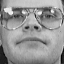

In [107]:
im = Image.fromarray(images[359] * 256)
new_im = im.convert('RGB')

display(new_im)

In [6]:
# X=images.reshape((images.shape[0],images.shape[1]*images.shape[2]))
# print("X shape:",X.shape)

X shape: (400, 4096)


In [108]:
class Dataset_(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

In [109]:
from sklearn.model_selection import train_test_split
import torch

# data = images.reshape(images.shape[0], images.shape[1] * images.shape[2])     # 64 X 64 = 4096

X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=.2, random_state=0)

batch_size = 50

train_set = Dataset_(X_train, y_train)
test_set = Dataset_(X_test, y_test)

train_set[0]


train_loader = torch.utils.data.DataLoader(train_set, 
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, 
                                         batch_size=batch_size,
                                         shuffle=False)

In [111]:
display(len(np.unique(target)))
np.unique(target)

40

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [112]:
features, labels=next(iter(test_loader))

In [113]:
ex1 = features[0]
ex1 = torch.unsqueeze(ex1, 0)
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(1, 60, kernel_size=5)
ex2 = F.max_pool2d(conv1(ex1), 2)
print('ex2:', ex2.shape)

conv2 = nn.Conv2d(60, 120, kernel_size=5)
ex3 = F.max_pool2d(conv2(ex2), 2)
print('ex4:', ex3.shape)


ex1: torch.Size([1, 64, 64])
ex2: torch.Size([60, 30, 30])
ex4: torch.Size([120, 13, 13])


In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, kernel_size=5)
        self.conv2 = nn.Conv2d(30, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*13*13, 60)
        self.fc2 = nn.Linear(60, 50)
        self.fc3 = nn.Linear(50, 40)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*13*13) 
        x = F.tanh(self.fc1(x)) 
        x = F.tanh(self.fc2(x)) 
        x = self.fc3(x) 
        return x
  

In [117]:
n_epoch = 20 + 1
lr=0.05
criterion = nn.CrossEntropyLoss()

model = Net()
optimizer = optim.Adam(model.parameters(), lr = lr)
losses_list = []
log_interval = 1

for epoch in range(n_epoch): 
    running_loss = 0
    for images, target in train_loader:
        images = torch.unsqueeze(images, 1)
        # images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, target.to(torch.long))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = running_loss/len(train_loader)
    if epoch % log_interval == 0:
      print("Epoch: {}/{} |".format(epoch, n_epoch),
            "Training loss: {:.3f}..".format(losses))
    losses_list.append(losses)
print('Finished Training')

Epoch: 0/21 | Training loss: 4.409..
Epoch: 1/21 | Training loss: 4.462..
Epoch: 2/21 | Training loss: 4.338..
Epoch: 3/21 | Training loss: 4.224..
Epoch: 4/21 | Training loss: 4.113..
Epoch: 5/21 | Training loss: 4.043..
Epoch: 6/21 | Training loss: 4.092..
Epoch: 7/21 | Training loss: 4.036..
Epoch: 8/21 | Training loss: 4.012..
Epoch: 9/21 | Training loss: 4.027..
Epoch: 10/21 | Training loss: 4.062..
Epoch: 11/21 | Training loss: 4.108..
Epoch: 12/21 | Training loss: 4.108..
Epoch: 13/21 | Training loss: 4.156..
Epoch: 14/21 | Training loss: 4.122..
Epoch: 15/21 | Training loss: 4.104..
Epoch: 16/21 | Training loss: 4.078..
Epoch: 17/21 | Training loss: 4.037..
Epoch: 18/21 | Training loss: 4.051..
Epoch: 19/21 | Training loss: 4.025..
Epoch: 20/21 | Training loss: 3.994..
Finished Training


In [134]:
model.eval() # equivalent with self.train(False) 
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for images, target in train_loader:
        images = torch.unsqueeze(images, 1)
        output = model(images)
        test_loss += criterion(output, target.to(torch.long))
        _, pred = torch.max(output, 1)
        # pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-p 
        correct = pred.eq(target.view_as(pred))        
        for i in range(20):
            target_i = target[i].item()
            try:
              result_v[target_i] += 1
            except:
              result_v[target_i] = 1
            try:
              result_[target_i] += 1
            except:
              result_[target_i] = int(correct[i].item())
        # correct += pred.eq(target.view_as(pred)).sum().item()
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_loader.dataset)

print(f'Avg. loss: {test_loss:.4f}')
for i in range(40):
    print(f'n{i} => {result_[i]/result_v[i]:.2f}({result_[i]}/{result_v[i]})')

Avg. loss: 0.3332
n0 => 0.67(2/3)
n1 => 0.67(2/3)
n2 => 0.75(3/4)
n3 => 0.75(3/4)
n4 => 0.75(3/4)
n5 => 0.50(1/2)
n6 => 0.50(1/2)
n7 => 0.80(4/5)
n8 => 0.00(0/1)
n9 => 0.80(4/5)
n10 => 0.67(2/3)
n11 => 0.75(3/4)
n12 => 0.67(2/3)
n13 => 0.67(2/3)
n14 => 0.67(2/3)
n15 => 0.67(2/3)
n16 => 0.80(4/5)
n17 => 0.50(1/2)
n18 => 0.00(0/1)
n19 => 0.75(3/4)
n20 => 0.80(4/5)
n21 => 0.67(2/3)
n22 => 0.83(5/6)
n23 => 0.86(6/7)
n24 => 0.67(2/3)
n25 => 0.88(7/8)
n26 => 0.75(3/4)
n27 => 0.80(4/5)
n28 => 0.75(3/4)
n29 => 0.75(3/4)
n30 => 0.00(0/1)
n31 => 0.50(1/2)
n32 => 0.50(1/2)
n33 => 1.00(3/3)
n34 => 0.00(0/1)
n35 => 0.75(3/4)
n36 => 0.67(2/3)
n37 => 0.67(2/3)
n38 => 0.75(3/4)
n39 => 0.75(3/4)


# Отчетность

В первую очередь в работе должна быть продемонстрирована ваша архитектура и процесс обучения (с кратким обоснованием выбора гиперпараметров).


Далее:

(В конце вашего ноутбука укажите следующие данные)

По задачам классификации:

1.  Вывести метрики классификации на тестовом множестве: accuracy, precision, recall и f1-score(для бинарной) и метрик качества для каждого класса, в случае использования датасета с лицами.
2.  Обосновать выбранное соотношение train/test на основе построения кривых обучения (или понятного вывода результатов эксперимента) 



По задаче регрессии:



1.   Вывести коэффициент детерминации и средний квадрат ошибки
2.   Продемнострировать, что выбрано оптимальное соотношение train/test, путем перебора всех содержательных вариантов.

